# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C103        S

## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [4]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [5]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [6]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [7]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

Embarked=C  Embarked=Q  Embarked=S
1            1           0           0
3            0           0           1
6            0           0           1
10           0           0           1
11           0           0           1

In [8]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [10]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [11]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [12]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [13]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [14]:
df_wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [15]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [16]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality_cat  
0      9.4            0  
1      9.8            0  
2      9.8            0  
3      9.8            1  
4      9.4            0

Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

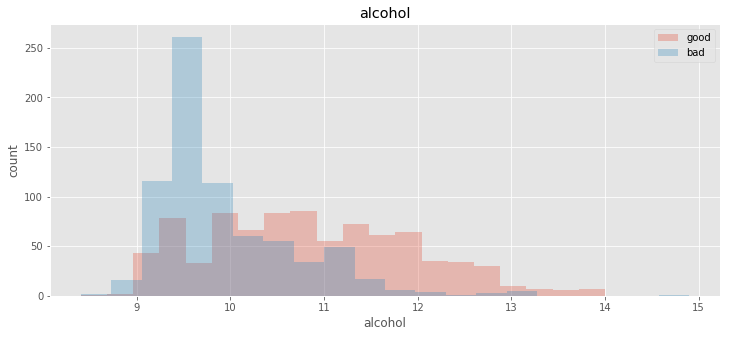

In [17]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [18]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [20]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [21]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [22]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [23]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality_cat  
0      8.8            1  
1      9.5            1  
2     10.1            1  
3      9.9            1  
4      9.9            1

In [24]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [25]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', eps=0.001):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.eps = eps
        
    def cent(self, X):
        n = 1
        Sum = 0
        self.centroids[0] = X[np.random.choice(np.arange(len(X)), 1), :]
        while n < self.k:
            self.labels = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids[:n,]]) for x_i in X])
            for i in xrange(len(self.labels)):
                Sum += np.dot(X[i]-self.centroids[self.labels[i]], X[i]-self.centroids[self.labels[i]])
            rnd = np.random.random() * Sum
            Sum = 0
            for i in xrange(len(self.labels)):
                Sum += np.dot(X[i]-self.centroids[self.labels[i]], X[i]-self.centroids[self.labels[i]])
                if Sum > rnd:
                    self.centroids[n] = X[i]
                    n += 1
                    break
                
        

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        # ...
        if y is None:
            if self.init == 'random':
                self.centroids = X[np.random.choice(np.arange(len(X)), self.k), :]
            elif self.init == 'k-means':
                self.cent(X)

            for i in range(self.max_iter):
                print i
                self.labels = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids]) for x_i in X])
                centro = [X[self.labels == j].mean(axis = 0) for j in range(self.k)]
                diff = [0]*self.k
                for j in range(self.k):
                    diff[j] = np.dot(centro[j] - self.centroids[j],centro[j] - self.centroids[j])
                if np.all([-self.eps < j < self.eps for j in diff]):
                    return self
                else:
                    self.centroids = centro
        else:
            self.labels = y
            self.centroids = [X[self.labels == j].mean(axis = 0) for j in range(self.k)]
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        if y is None:
            return np.array([np.argmin([np.dot(x-y_k, x-y_k) for y_k in self.centroids]) for x in X])
        else:
            return y

class MiniBatchKMeans(Kmeans):
    def __init__(self, batch_size = 10000, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', eps=0.001):
        self.batch_size = batch_size
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.eps = eps
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        # ...
        if y is None:
            if self.init == 'random':
                self.centroids = X[np.random.choice(np.arange(len(X)), self.k,replace=False), :]
            elif self.init == 'k-means':
                self.cent(X)

            l = min(self.batch_size, len(X))
            a = []
            for i in range(self.max_iter):
                print i
                r = np.random.choice(np.arange(len(X)), l)
                r = a[np.arange(len(a))!=3]
                self.labels = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in self.centroids]) for x_i in X])
                centro = [X[r,:][self.labels[r] == j].mean(axis = 0) for j in range(self.k)]
                diff = [0]*self.k
                for j in range(self.k):
                    diff[j] = np.dot(centro[j] - self.centroids[j],centro[j] - self.centroids[j])
                if np.all([-self.eps < j < self.eps for j in diff]):
                    return self
                self.centroids += (centro - self.centroids)*(l/len(X))
        else:
            self.labels = y
            self.centroids = [X[self.labels == j].mean(axis = 0) for j in range(self.k)]
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [230]:
from sklearn.datasets import make_blobs

In [231]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

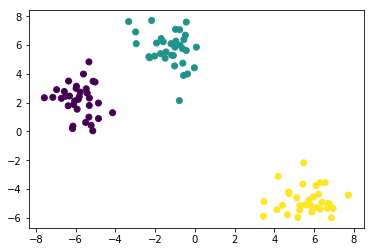

In [232]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

0
1
2
3
4
5
6


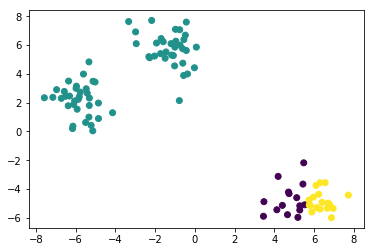

In [233]:
## Работоспособность KMeans
model = Kmeans(k=3)
model.fit(X)
r = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=r)

0
1
2


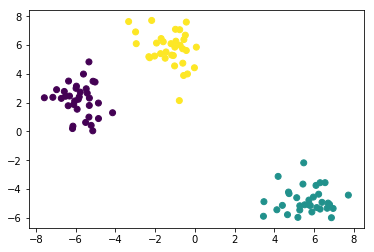

In [234]:
## Работоспособность KMeans++
model = Kmeans(k=3, init='k-means')
model.fit(X)
r = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=r)

0
[array([[-6.13346906,  0.36719782],
       [-1.49387727,  5.08946503],
       [-7.14384733,  2.37183054],
       [-0.55134193,  6.38580135],
       [-0.02087086,  4.4260634 ],
       [-5.12203242,  3.48811368],
       [ 6.09565909, -3.75155303],
       [-5.97618962,  2.99561433],
       [-6.50368836,  2.44429379],
       [-6.30640583,  2.46046461],
       [-0.42931799,  7.60070614],
       [ 7.72320805, -4.42587446],
       [-1.59021123,  6.23545982],
       [ 4.66136355, -5.78721946],
       [ 4.40399242, -5.14001087],
       [-5.13581026,  0.04172179],
       [ 0.0756604 ,  5.85980223],
       [ 4.12639975, -5.44472851],
       [-5.12203242,  3.48811368],
       [ 6.87191124, -5.9977145 ],
       [-0.42931799,  7.60070614],
       [-5.31002258,  1.80565192],
       [-5.86164214,  2.23367666],
       [ 6.30207839, -5.39849417],
       [-2.98079409,  6.91755538],
       [-7.57158427,  2.34125722],
       [-5.92181879,  1.54501864],
       [-0.60581246,  4.74514284],
       [-2.026550

       [-0.61346577,  5.74668436]])]
44
[array([[-0.55134193,  6.38580135],
       [-1.49387727,  5.08946503],
       [-2.314434  ,  5.19529037],
       [ 3.45166112, -5.89568041],
       [-5.86164214,  2.23367666],
       [-1.16560291,  5.30720709],
       [ 7.72320805, -4.42587446],
       [-6.56745122,  2.77961307],
       [-1.49387727,  5.08946503],
       [-2.98079409,  6.91755538],
       [ 6.39695158, -4.92795868],
       [-2.314434  ,  5.19529037],
       [-6.04489804,  2.11938062],
       [-5.81559066,  2.4066624 ],
       [ 6.65714935, -5.3396367 ],
       [-0.55134193,  6.38580135],
       [-0.47807648,  6.69209152],
       [-0.74185346,  5.99246736],
       [-1.44937809,  5.52499626],
       [-0.61346577,  5.74668436],
       [-5.3058937 ,  2.32008385],
       [ 5.12549527, -4.60484361],
       [ 6.39695158, -4.92795868],
       [ 5.96308072, -4.56290001],
       [-5.95772761,  3.14689605],
       [ 6.39695158, -4.92795868],
       [-0.47807648,  6.69209152],
       [-5.603

       [-6.37225732,  1.78620608]])]
91
[array([[-6.71785344,  2.29755591],
       [ 3.45166112, -5.89568041],
       [-6.35271953,  3.50114461],
       [-1.59021123,  6.23545982],
       [-6.13346906,  0.36719782],
       [-0.02087086,  4.4260634 ],
       [ 7.72320805, -4.42587446],
       [ 6.30042389, -3.56395982],
       [-2.0265505 ,  5.23915401],
       [-0.36996972,  3.99645635],
       [-0.36996972,  3.99645635],
       [ 6.39695158, -4.92795868],
       [ 6.70386773, -4.97969741],
       [ 5.80891095, -5.1410339 ],
       [-6.56745122,  2.77961307],
       [-5.95772761,  3.14689605],
       [-5.97618962,  2.99561433],
       [-1.44937809,  5.52499626],
       [-1.92832922,  6.14342928],
       [ 4.12639975, -5.44472851],
       [ 5.27931228, -5.46434676],
       [ 5.18501132, -5.97394263],
       [-1.00588922,  5.8583983 ],
       [ 5.27995476, -5.16814098],
       [ 4.12639975, -5.44472851],
       [ 6.65714935, -5.3396367 ],
       [-4.85145944,  1.97287014],
       [-1.724

136
[array([[-6.9550462 ,  2.90423516],
       [ 3.47589591, -4.88165033],
       [-1.00588922,  5.8583983 ],
       [ 3.47589591, -4.88165033],
       [-4.13900737,  1.29954413],
       [-5.97618962,  2.99561433],
       [-0.42885129,  5.62522462],
       [-5.86164214,  2.23367666],
       [ 6.22829199, -4.36165355],
       [ 5.73919944, -4.77116688],
       [ 6.70386773, -4.97969741],
       [ 6.77632861, -5.072484  ],
       [ 7.72320805, -4.42587446],
       [-7.57158427,  2.34125722],
       [-6.50368836,  2.44429379],
       [-0.76115711,  7.07065319],
       [-5.3286022 ,  0.99636534],
       [ 6.30207839, -5.39849417],
       [ 5.80891095, -5.1410339 ],
       [-4.8484528 ,  0.89526987],
       [ 6.65714935, -5.3396367 ],
       [-1.59021123,  6.23545982],
       [ 5.73919944, -4.77116688],
       [-5.81559066,  2.4066624 ],
       [ 6.13629999, -5.29197826],
       [ 4.19008442, -3.12516194],
       [ 3.45166112, -5.89568041],
       [-5.95772761,  3.14689605],
       [-0.6058

[array([[ 4.40399242, -5.14001087],
       [-2.98079409,  6.91755538],
       [-6.56745122,  2.77961307],
       [-4.13900737,  1.29954413],
       [-2.98079409,  6.91755538],
       [ 6.70386773, -4.97969741],
       [ 6.87191124, -5.9977145 ],
       [-5.60387269,  3.98783423],
       [-4.85145944,  1.97287014],
       [-5.46538277,  2.96568339],
       [ 7.72320805, -4.42587446],
       [-6.9550462 ,  2.90423516],
       [-6.35271953,  3.50114461],
       [-5.31002258,  1.80565192],
       [-6.0934114 ,  1.87572949],
       [-5.49405691,  0.62514819],
       [ 7.72320805, -4.42587446],
       [ 4.66136355, -5.78721946],
       [-5.31002258,  1.80565192],
       [-0.61346577,  5.74668436],
       [ 3.47589591, -4.88165033],
       [ 6.77632861, -5.072484  ],
       [ 5.43837925, -3.6589904 ],
       [ 6.70386773, -4.97969741],
       [-0.97460937,  7.09915787],
       [ 3.45166112, -5.89568041],
       [-5.3286022 ,  0.99636534],
       [-6.0934114 ,  1.87572949],
       [-2.314434  

228
[array([[-2.98079409,  6.91755538],
       [ 7.72320805, -4.42587446],
       [-5.21628686,  0.4209206 ],
       [-0.95423986,  6.27370537],
       [ 6.70386773, -4.97969741],
       [-2.314434  ,  5.19529037],
       [-1.72476922,  5.40815538],
       [ 6.13629999, -5.29197826],
       [-5.3058937 ,  2.32008385],
       [ 0.0756604 ,  5.85980223],
       [-0.47807648,  6.69209152],
       [-6.56745122,  2.77961307],
       [-1.08091568,  5.27707598],
       [ 6.09565909, -3.75155303],
       [-5.32793628,  4.83313594],
       [ 4.66136355, -5.78721946],
       [-6.15391462,  0.19949047],
       [ 4.40399242, -5.14001087],
       [-1.72476922,  5.40815538],
       [-4.85145944,  1.97287014],
       [ 5.43837925, -3.6589904 ],
       [-5.92181879,  1.54501864],
       [-5.81559066,  2.4066624 ],
       [-4.8484528 ,  0.89526987],
       [-2.314434  ,  5.19529037],
       [-6.13346906,  0.36719782],
       [-1.01848268,  4.55451257],
       [ 7.72320805, -4.42587446],
       [ 5.9630

[array([[-6.35271953,  3.50114461],
       [ 5.12549527, -4.60484361],
       [-7.57158427,  2.34125722],
       [ 5.80891095, -5.1410339 ],
       [-0.95423986,  6.27370537],
       [ 4.71279681, -4.21394996],
       [-2.98079409,  6.91755538],
       [-7.14384733,  2.37183054],
       [-0.97460937,  7.09915787],
       [-5.31002258,  1.80565192],
       [ 6.77632861, -5.072484  ],
       [-1.44937809,  5.52499626],
       [ 5.75651454, -5.11960325],
       [-5.31002258,  1.80565192],
       [-0.76115711,  7.07065319],
       [-1.92832922,  6.14342928],
       [ 6.30207839, -5.39849417],
       [-0.56478922,  3.88867268],
       [-0.97460937,  7.09915787],
       [-5.81559066,  2.4066624 ],
       [-1.01848268,  4.55451257],
       [ 5.52690785, -5.09875082],
       [-7.57158427,  2.34125722],
       [-1.92832922,  6.14342928],
       [-3.33071086,  7.63741844],
       [ 5.12549527, -4.60484361],
       [-5.76415758,  2.73126736],
       [-5.86164214,  2.23367666],
       [ 4.71279681

[array([[-6.50368836,  2.44429379],
       [ 6.55199451, -3.56001031],
       [ 6.39695158, -4.92795868],
       [-4.8484528 ,  0.89526987],
       [-0.60581246,  4.74514284],
       [ 6.13629999, -5.29197826],
       [-6.04489804,  2.11938062],
       [-5.86164214,  2.23367666],
       [ 5.18501132, -5.97394263],
       [-1.49387727,  5.08946503],
       [ 6.30042389, -3.56395982],
       [-5.41419701,  2.657444  ],
       [-0.36996972,  3.99645635],
       [-4.13900737,  1.29954413],
       [-5.49405691,  0.62514819],
       [ 7.72320805, -4.42587446],
       [-7.57158427,  2.34125722],
       [-0.95423986,  6.27370537],
       [ 6.77632861, -5.072484  ],
       [-6.04489804,  2.11938062],
       [-5.97618962,  2.99561433],
       [-5.76415758,  2.73126736],
       [-0.42885129,  5.62522462],
       [ 5.52690785, -5.09875082],
       [ 6.65714935, -5.3396367 ],
       [ 5.12549527, -4.60484361],
       [ 6.22829199, -4.36165355],
       [ 6.55199451, -3.56001031],
       [-5.92181879

[array([[-5.01957527,  3.43412144],
       [ 6.70386773, -4.97969741],
       [-0.76115711,  7.07065319],
       [-0.56478922,  3.88867268],
       [-4.85145944,  1.97287014],
       [-6.15391462,  0.19949047],
       [-6.35271953,  3.50114461],
       [ 5.27995476, -5.16814098],
       [ 4.19008442, -3.12516194],
       [-1.08091568,  5.27707598],
       [-6.71785344,  2.29755591],
       [ 0.0756604 ,  5.85980223],
       [-1.49387727,  5.08946503],
       [-1.01848268,  4.55451257],
       [-4.8484528 ,  0.89526987],
       [-1.08091568,  5.27707598],
       [-5.81559066,  2.4066624 ],
       [-0.36996972,  3.99645635],
       [-5.13581026,  0.04172179],
       [-0.42885129,  5.62522462],
       [-5.21628686,  0.4209206 ],
       [ 4.71279681, -4.21394996],
       [-1.19837358,  6.10201588],
       [-2.0265505 ,  5.23915401],
       [ 0.0756604 ,  5.85980223],
       [-6.9550462 ,  2.90423516],
       [-0.97460937,  7.09915787],
       [-0.61346577,  5.74668436],
       [ 6.09565909

[array([[-5.49405691,  0.62514819],
       [-2.314434  ,  5.19529037],
       [ 5.18501132, -5.97394263],
       [ 5.52690785, -5.09875082],
       [-4.13900737,  1.29954413],
       [ 4.40399242, -5.14001087],
       [-6.0934114 ,  1.87572949],
       [ 3.45166112, -5.89568041],
       [-1.01848268,  4.55451257],
       [-5.41419701,  2.657444  ],
       [-0.55134193,  6.38580135],
       [-1.69621032,  6.45633548],
       [-2.314434  ,  5.19529037],
       [-5.01957527,  3.43412144],
       [-2.314434  ,  5.19529037],
       [-6.15391462,  0.19949047],
       [ 6.55199451, -3.56001031],
       [-5.60387269,  3.98783423],
       [-2.98079409,  6.91755538],
       [-0.56478922,  3.88867268],
       [-6.15391462,  0.19949047],
       [ 6.22829199, -4.36165355],
       [-5.76415758,  2.73126736],
       [ 6.22829199, -4.36165355],
       [-0.55134193,  6.38580135],
       [ 3.45166112, -5.89568041],
       [-6.15391462,  0.19949047],
       [-5.21628686,  0.4209206 ],
       [-1.01848268

[array([[ 3.45166112, -5.89568041],
       [-6.37225732,  1.78620608],
       [-1.72476922,  5.40815538],
       [-2.94845799,  6.10088227],
       [-6.30640583,  2.46046461],
       [ 6.77632861, -5.072484  ],
       [ 5.88789301, -5.59968683],
       [ 6.30207839, -5.39849417],
       [-2.98079409,  6.91755538],
       [-4.13900737,  1.29954413],
       [ 5.52690785, -5.09875082],
       [-1.16560291,  5.30720709],
       [-5.76415758,  2.73126736],
       [-3.33071086,  7.63741844],
       [-7.57158427,  2.34125722],
       [ 6.55199451, -3.56001031],
       [-2.0265505 ,  5.23915401],
       [ 0.0756604 ,  5.85980223],
       [-5.13581026,  0.04172179],
       [-2.94845799,  6.10088227],
       [-6.15391462,  0.19949047],
       [ 4.12639975, -5.44472851],
       [ 4.12639975, -5.44472851],
       [-0.02087086,  4.4260634 ],
       [-6.15391462,  0.19949047],
       [-5.01957527,  3.43412144],
       [-5.97618962,  2.99561433],
       [-1.44937809,  5.52499626],
       [-1.59021123

[array([[ 0.0756604 ,  5.85980223],
       [-5.81559066,  2.4066624 ],
       [-0.78105289,  2.14365501],
       [-2.98079409,  6.91755538],
       [ 6.55199451, -3.56001031],
       [-6.37225732,  1.78620608],
       [-0.61346577,  5.74668436],
       [-5.12203242,  3.48811368],
       [-5.86164214,  2.23367666],
       [-0.74185346,  5.99246736],
       [ 6.30207839, -5.39849417],
       [ 7.72320805, -4.42587446],
       [-1.44937809,  5.52499626],
       [ 4.12639975, -5.44472851],
       [-1.00588922,  5.8583983 ],
       [-3.33071086,  7.63741844],
       [-5.32793628,  4.83313594],
       [ 5.52690785, -5.09875082],
       [-6.56745122,  2.77961307],
       [-0.42931799,  7.60070614],
       [ 6.13629999, -5.29197826],
       [ 6.13629999, -5.29197826],
       [-0.02087086,  4.4260634 ],
       [-4.85145944,  1.97287014],
       [-1.44937809,  5.52499626],
       [-6.13346906,  0.36719782],
       [-2.0265505 ,  5.23915401],
       [ 0.0756604 ,  5.85980223],
       [-5.49405691

[array([[ 6.95731342, -5.35298162],
       [-5.76415758,  2.73126736],
       [-1.92832922,  6.14342928],
       [ 4.71279681, -4.21394996],
       [-0.36996972,  3.99645635],
       [-0.02087086,  4.4260634 ],
       [-1.19837358,  6.10201588],
       [-5.97618962,  2.99561433],
       [-0.02087086,  4.4260634 ],
       [ 5.88789301, -5.59968683],
       [ 6.30207839, -5.39849417],
       [-0.56478922,  3.88867268],
       [-2.314434  ,  5.19529037],
       [-5.81559066,  2.4066624 ],
       [ 5.96308072, -4.56290001],
       [-1.16560291,  5.30720709],
       [-1.19837358,  6.10201588],
       [ 6.09565909, -3.75155303],
       [-1.44937809,  5.52499626],
       [-1.44937809,  5.52499626],
       [-0.61346577,  5.74668436],
       [ 5.27995476, -5.16814098],
       [-1.01848268,  4.55451257],
       [ 4.12639975, -5.44472851],
       [-1.08091568,  5.27707598],
       [ 5.47778775, -2.18237927],
       [ 5.73919944, -4.77116688],
       [-2.0265505 ,  5.23915401],
       [ 5.12549527

[array([[-1.44937809,  5.52499626],
       [ 5.27931228, -5.46434676],
       [-1.08091568,  5.27707598],
       [-5.3286022 ,  0.99636534],
       [-6.15391462,  0.19949047],
       [-1.01848268,  4.55451257],
       [-5.31002258,  1.80565192],
       [-6.13346906,  0.36719782],
       [-2.314434  ,  5.19529037],
       [-6.13346906,  0.36719782],
       [-7.57158427,  2.34125722],
       [-6.37225732,  1.78620608],
       [ 5.27931228, -5.46434676],
       [-7.14384733,  2.37183054],
       [-1.44937809,  5.52499626],
       [-0.76115711,  7.07065319],
       [-1.44937809,  5.52499626],
       [-0.60581246,  4.74514284],
       [ 5.88789301, -5.59968683],
       [-5.21628686,  0.4209206 ],
       [-1.49387727,  5.08946503],
       [-5.86164214,  2.23367666],
       [-5.86164214,  2.23367666],
       [ 6.65714935, -5.3396367 ],
       [-2.17169953,  7.71501463],
       [-1.00588922,  5.8583983 ],
       [-5.60387269,  3.98783423],
       [ 6.22829199, -4.36165355],
       [-5.32793628

633
[array([[-5.21628686,  0.4209206 ],
       [-0.42931799,  7.60070614],
       [-6.71785344,  2.29755591],
       [ 3.47589591, -4.88165033],
       [ 5.75651454, -5.11960325],
       [-5.97618962,  2.99561433],
       [ 5.52690785, -5.09875082],
       [-3.33071086,  7.63741844],
       [ 5.75651454, -5.11960325],
       [-6.13346906,  0.36719782],
       [ 6.77632861, -5.072484  ],
       [-6.30640583,  2.46046461],
       [-5.3286022 ,  0.99636534],
       [ 5.75651454, -5.11960325],
       [ 4.19008442, -3.12516194],
       [ 5.43837925, -3.6589904 ],
       [-0.47807648,  6.69209152],
       [-4.13900737,  1.29954413],
       [ 5.43837925, -3.6589904 ],
       [-1.59021123,  6.23545982],
       [-0.56478922,  3.88867268],
       [-2.314434  ,  5.19529037],
       [-1.01848268,  4.55451257],
       [ 4.73984786, -4.32216241],
       [ 4.71279681, -4.21394996],
       [-2.98079409,  6.91755538],
       [ 4.12639975, -5.44472851],
       [-5.12203242,  3.48811368],
       [ 0.0756

677
[array([[ 3.45166112, -5.89568041],
       [-4.85145944,  1.97287014],
       [-1.44937809,  5.52499626],
       [-0.78105289,  2.14365501],
       [-6.04489804,  2.11938062],
       [-5.46538277,  2.96568339],
       [ 6.30042389, -3.56395982],
       [ 5.80891095, -5.1410339 ],
       [ 6.65714935, -5.3396367 ],
       [ 6.30207839, -5.39849417],
       [-5.92181879,  1.54501864],
       [-6.35271953,  3.50114461],
       [ 4.71279681, -4.21394996],
       [-5.49405691,  0.62514819],
       [ 6.55199451, -3.56001031],
       [ 6.87191124, -5.9977145 ],
       [ 5.80891095, -5.1410339 ],
       [-5.3286022 ,  0.99636534],
       [ 3.45166112, -5.89568041],
       [ 6.30207839, -5.39849417],
       [-6.37225732,  1.78620608],
       [ 0.0756604 ,  5.85980223],
       [-1.92832922,  6.14342928],
       [-6.04489804,  2.11938062],
       [-5.60387269,  3.98783423],
       [-4.13900737,  1.29954413],
       [-0.36996972,  3.99645635],
       [-3.33071086,  7.63741844],
       [-5.8155

[array([[-6.71785344,  2.29755591],
       [ 3.47589591, -4.88165033],
       [-6.04489804,  2.11938062],
       [ 3.45166112, -5.89568041],
       [ 5.18501132, -5.97394263],
       [-0.78105289,  2.14365501],
       [-5.3286022 ,  0.99636534],
       [-4.85145944,  1.97287014],
       [ 5.12549527, -4.60484361],
       [-5.01957527,  3.43412144],
       [-6.50368836,  2.44429379],
       [-5.46538277,  2.96568339],
       [-6.0934114 ,  1.87572949],
       [-0.60581246,  4.74514284],
       [ 5.75651454, -5.11960325],
       [-0.74185346,  5.99246736],
       [-5.46538277,  2.96568339],
       [-1.00588922,  5.8583983 ],
       [ 4.71279681, -4.21394996],
       [-0.42931799,  7.60070614],
       [ 4.12639975, -5.44472851],
       [-5.3058937 ,  2.32008385],
       [ 7.72320805, -4.42587446],
       [-5.3286022 ,  0.99636534],
       [-5.01957527,  3.43412144],
       [ 6.77632861, -5.072484  ],
       [-5.31002258,  1.80565192],
       [ 6.13629999, -5.29197826],
       [-0.47807648

764
[array([[-0.56478922,  3.88867268],
       [ 6.65714935, -5.3396367 ],
       [-0.61346577,  5.74668436],
       [-0.78105289,  2.14365501],
       [-5.13581026,  0.04172179],
       [-0.61346577,  5.74668436],
       [ 5.73919944, -4.77116688],
       [-1.44937809,  5.52499626],
       [ 6.13629999, -5.29197826],
       [-1.16560291,  5.30720709],
       [-6.13346906,  0.36719782],
       [-2.0265505 ,  5.23915401],
       [ 5.80891095, -5.1410339 ],
       [-5.41419701,  2.657444  ],
       [ 6.39695158, -4.92795868],
       [-0.02087086,  4.4260634 ],
       [-2.27329578,  5.12245346],
       [-6.37225732,  1.78620608],
       [-5.60387269,  3.98783423],
       [-5.12203242,  3.48811368],
       [-6.35271953,  3.50114461],
       [ 5.75651454, -5.11960325],
       [ 5.52690785, -5.09875082],
       [-5.81559066,  2.4066624 ],
       [-5.31002258,  1.80565192],
       [ 6.39695158, -4.92795868],
       [-1.69621032,  6.45633548],
       [-0.60581246,  4.74514284],
       [-1.0058

808
[array([[-5.60387269,  3.98783423],
       [ 4.73984786, -4.32216241],
       [-0.55134193,  6.38580135],
       [-6.30640583,  2.46046461],
       [-6.56745122,  2.77961307],
       [-5.21628686,  0.4209206 ],
       [ 5.80891095, -5.1410339 ],
       [ 5.52690785, -5.09875082],
       [-6.71785344,  2.29755591],
       [ 6.39695158, -4.92795868],
       [ 5.43837925, -3.6589904 ],
       [-2.314434  ,  5.19529037],
       [ 6.65714935, -5.3396367 ],
       [-1.19837358,  6.10201588],
       [ 5.73919944, -4.77116688],
       [ 5.47778775, -2.18237927],
       [-0.42885129,  5.62522462],
       [-1.69621032,  6.45633548],
       [-5.97618962,  2.99561433],
       [-0.55134193,  6.38580135],
       [ 3.47589591, -4.88165033],
       [-4.85145944,  1.97287014],
       [-6.35271953,  3.50114461],
       [-4.85145944,  1.97287014],
       [-4.85145944,  1.97287014],
       [-6.13346906,  0.36719782],
       [-7.57158427,  2.34125722],
       [-0.42885129,  5.62522462],
       [-5.8155

[array([[-6.04489804,  2.11938062],
       [-1.44937809,  5.52499626],
       [-5.31002258,  1.80565192],
       [-7.57158427,  2.34125722],
       [-5.21628686,  0.4209206 ],
       [ 6.77632861, -5.072484  ],
       [-2.98079409,  6.91755538],
       [-6.37225732,  1.78620608],
       [-2.314434  ,  5.19529037],
       [ 7.72320805, -4.42587446],
       [-2.17169953,  7.71501463],
       [-0.74185346,  5.99246736],
       [-5.76415758,  2.73126736],
       [-6.04489804,  2.11938062],
       [-6.50368836,  2.44429379],
       [-0.56478922,  3.88867268],
       [-5.32793628,  4.83313594],
       [ 5.27995476, -5.16814098],
       [ 5.73919944, -4.77116688],
       [-5.49405691,  0.62514819],
       [-0.42885129,  5.62522462],
       [-6.30640583,  2.46046461],
       [-5.3286022 ,  0.99636534],
       [-5.41419701,  2.657444  ],
       [ 5.27931228, -5.46434676],
       [-5.60387269,  3.98783423],
       [-1.16560291,  5.30720709],
       [-0.36996972,  3.99645635],
       [-2.17169953

[array([[ 6.09565909, -3.75155303],
       [ 5.80891095, -5.1410339 ],
       [-1.92832922,  6.14342928],
       [-5.41419701,  2.657444  ],
       [-0.97460937,  7.09915787],
       [ 5.27995476, -5.16814098],
       [-2.314434  ,  5.19529037],
       [-4.8484528 ,  0.89526987],
       [ 5.18501132, -5.97394263],
       [ 4.40399242, -5.14001087],
       [-0.02087086,  4.4260634 ],
       [-5.13581026,  0.04172179],
       [-7.57158427,  2.34125722],
       [-5.81559066,  2.4066624 ],
       [-1.08091568,  5.27707598],
       [-1.92832922,  6.14342928],
       [ 4.19008442, -3.12516194],
       [-6.9550462 ,  2.90423516],
       [ 5.47778775, -2.18237927],
       [-5.3058937 ,  2.32008385],
       [-5.81559066,  2.4066624 ],
       [-0.97460937,  7.09915787],
       [-4.8484528 ,  0.89526987],
       [ 4.71279681, -4.21394996],
       [-6.50368836,  2.44429379],
       [-0.42885129,  5.62522462],
       [ 3.47589591, -4.88165033],
       [-0.55134193,  6.38580135],
       [-1.59021123

[array([[ 6.13629999, -5.29197826],
       [-0.42931799,  7.60070614],
       [-2.17169953,  7.71501463],
       [-0.42931799,  7.60070614],
       [-5.12203242,  3.48811368],
       [-1.01848268,  4.55451257],
       [-4.85145944,  1.97287014],
       [ 5.47778775, -2.18237927],
       [ 5.73919944, -4.77116688],
       [-4.85145944,  1.97287014],
       [-6.50368836,  2.44429379],
       [-7.14384733,  2.37183054],
       [-5.60387269,  3.98783423],
       [-5.49405691,  0.62514819],
       [-2.314434  ,  5.19529037],
       [ 6.30207839, -5.39849417],
       [ 5.75651454, -5.11960325],
       [ 5.80891095, -5.1410339 ],
       [-0.56478922,  3.88867268],
       [-5.97618962,  2.99561433],
       [ 5.73919944, -4.77116688],
       [-0.78105289,  2.14365501],
       [ 4.73984786, -4.32216241],
       [-5.76415758,  2.73126736],
       [ 5.27931228, -5.46434676],
       [-0.97460937,  7.09915787],
       [-0.76115711,  7.07065319],
       [-6.9550462 ,  2.90423516],
       [ 6.09565909

993
[array([[-1.08091568,  5.27707598],
       [-0.42931799,  7.60070614],
       [-2.0265505 ,  5.23915401],
       [-0.42885129,  5.62522462],
       [-1.08091568,  5.27707598],
       [ 6.55199451, -3.56001031],
       [ 5.80891095, -5.1410339 ],
       [-1.08091568,  5.27707598],
       [ 4.71279681, -4.21394996],
       [-0.78105289,  2.14365501],
       [-5.49405691,  0.62514819],
       [ 5.27995476, -5.16814098],
       [ 4.19008442, -3.12516194],
       [-0.61346577,  5.74668436],
       [-0.76115711,  7.07065319],
       [-0.74185346,  5.99246736],
       [-5.21628686,  0.4209206 ],
       [-7.57158427,  2.34125722],
       [-0.78105289,  2.14365501],
       [-5.97618962,  2.99561433],
       [-6.13346906,  0.36719782],
       [-0.47807648,  6.69209152],
       [-1.00588922,  5.8583983 ],
       [-5.32793628,  4.83313594],
       [ 4.12639975, -5.44472851],
       [-6.0934114 ,  1.87572949],
       [ 6.39695158, -4.92795868],
       [-6.71785344,  2.29755591],
       [ 6.3004

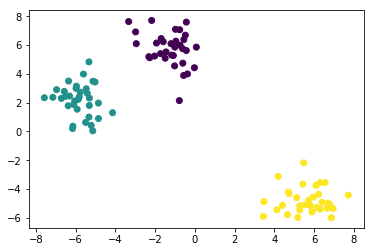

In [235]:
## Работоспособность KMeans с MiniBatchKMeans
model = MiniBatchKMeans(k=3)
model.fit(X)
r = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=r)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

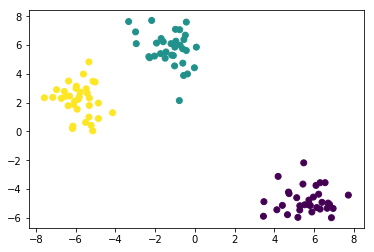

In [182]:
## Работоспособность KMeans++ с MiniBatchKMeans
model = MiniBatchKMeans(k=3, init='k-means')
model.fit(X)
r = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=r)

In [60]:
## Время выполнения алгоритма KMeans
import timeit
x = [0,0,0,0,0]
for i in xrange(5):
    X, y = make_blobs(n_samples=(10**(i+1)), n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    s = timeit.default_timer()
    model = Kmeans(k=3)
    model.fit(X)
    f = timeit.default_timer()
    x[i] = f-s
plt.figure()
plt.plot([1,2,3,4,5],x)

KeyboardInterrupt: 

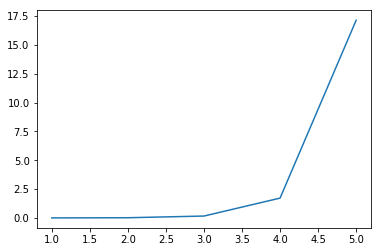

In [468]:
## Время выполнения алгоритма KMeans++
x = [0,0,0,0,0]
for i in xrange(5):
    X, y = make_blobs(n_samples=10**(i+1), n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    s = timeit.default_timer()
    model = Kmeans(k=3, init='k-means')
    model.fit(X)
    f = timeit.default_timer()
    x[i] = f-s
plt.plot(["1","2","3","4","5"],x)

/home/nikita/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: Mean of empty slice.


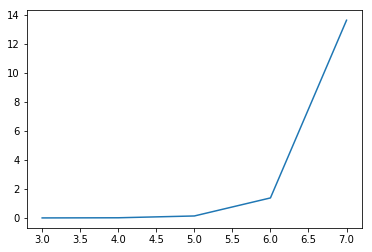

In [470]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
x = [1,2,3,4,5]
for i in xrange(5):
    X, y = make_blobs(n_samples=10**(i+1), n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    s = timeit.default_timer()
    model = MiniBatchKMeans(k=3)
    model.fit(X)
    f = timeit.default_timer()
    x[i] = f-s
plt.plot(["3","4","5","6","7"],x)

In [ ]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [74]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

gradyear gender     age  friends  basketball  football  soccer  softball  \
0      2006      M  18.982        7           0         0       0         0   
1      2006      F  18.801        0           0         1       0         0   
2      2006      M  18.335       69           0         1       0         0   
3      2006      F  18.875        0           0         0       0         0   
4      2006    NaN  18.995       10           0         0       0         0   

   volleyball  swimming  ...    blonde  mall  shopping  clothes  hollister  \
0           0         0  ...         0     0         0        0          0   
1           0         0  ...         0     1         0        0          0   
2           0         0  ...         0     0         0        0          0   
3           0         0  ...         0     0         0        0          0   
4           0         0  ...         0     0         2        0          0   

   abercrombie  die  death  drunk  drugs  
0            0    0      0      0      0  
1            0    0      0      0      0  
2            0    0      1      0      0  
3            0    0      0      0      0  
4            0    0      0      1      1  

[5 rows x 40 columns]

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [75]:
## KMeans
df_sns = df_sns.drop([u'age',u'gradyear',u'gender',u'friends'], axis='columns')
df_sns = df_sns
df_sns.head()

basketball  football  soccer  softball  volleyball  swimming  cheerleading  \
0           0         0       0         0           0         0             0   
1           0         1       0         0           0         0             0   
2           0         1       0         0           0         0             0   
3           0         0       0         0           0         0             0   
4           0         0       0         0           0         0             0   

   baseball  tennis  sports  ...    blonde  mall  shopping  clothes  \
0         0       0       0  ...         0     0         0        0   
1         0       0       0  ...         0     1         0        0   
2         0       0       0  ...         0     0         0        0   
3         0       0       0  ...         0     0         0        0   
4         0       0       0  ...         0     0         2        0   

   hollister  abercrombie  die  death  drunk  drugs  
0          0            0    0      0      0      0  
1          0            0    0      0      0      0  
2          0            0    0      1      0      0  
3          0            0    0      0      0      0  
4          0            0    0      0      1      1  

[5 rows x 36 columns]

In [ ]:
## KMeans++

In [ ]:
## KMeans с MiniBatchKMeans

In [ ]:
## KMeans++ с MiniBatchKMeans

In [ ]:
## Вывод